In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
cd Resources


C:\Users\Thoma\Resources


In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

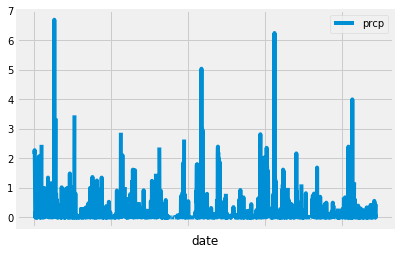

In [74]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_point = session.query(func.max(Measurement.date)).first()[0]
last_date = dt.datetime.strptime(last_point, '%Y-%m-%d').date()
one_yr_prior = last_date - dt.timedelta(days=365.25)
#one_yr_prior

# Perform a query to retrieve the data and precipitation scores

precipitation = session.query(Measurement).filter(Measurement.date > one_yr_prior).filter(Measurement.date <= last_date)

# Save the query results as a Pandas DataFrame and set the index to the date column

df_precip = pd.read_sql(precipitation.statement, session.bind)
precip_by_date = pd.DataFrame(df_precip[:], columns=['date','prcp'])
precip_by_date = precip_by_date.set_index('date')


# Sort the dataframe by date
precip_by_date = precip_by_date.sort_index()
precip_by_date


# Use Pandas Plotting with Matplotlib to plot the data
precip_plot = precip_by_date.plot()
plt.show()

![precipitation](Images/precipitation.png)

In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_by_date.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [77]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [84]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [106]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
              group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_stats

(54.0, 85.0, 71.66378066378067)

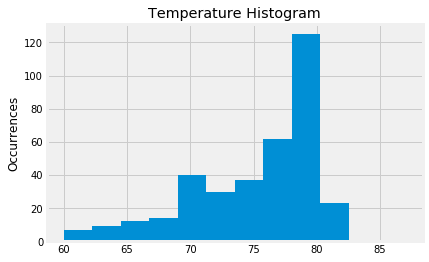

In [142]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs = session.query(Measurement.station, func.count(Measurement.station)).\
              filter(Measurement.date > '2016-08-23').\
              group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_obs
most_obs_temps = session.query(Measurement.tobs).filter(Measurement.station== 'USC00519397')\
.filter(Measurement.date>=one_yr_prior).all()
obs_df = pd.DataFrame(most_obs_temps, columns = ['Temps'])
obs_df.hist(bins=12)
plt.title ("Temperature Histogram")
plt.ylabel("Occurrences")
plt.show()

![precipitation](Images/station-histogram.png)

In [109]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [127]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2016-08-23'
end_date = '2017-8-23'
tmin = calc_temps(start_date, end_date)[0][0]
tavg = calc_temps(start_date, end_date)[0][1]
tmax = calc_temps(start_date, end_date)[0][2]
print(tmin, tavg, tmax)

58.0 74.59058295964125 87.0


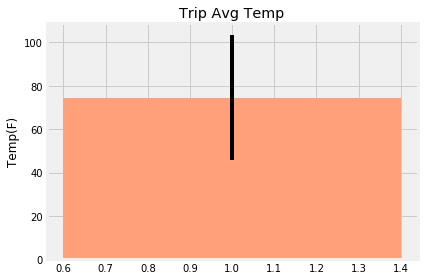

In [178]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(1,height=tavg, yerr=(tmax-tmin),color="lightsalmon")
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [138]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_by_station = session.query(Station.station,Station.name, Station.latitude,Station.longitude,Station.elevation,func.avg(Measurement.prcp))\
.filter(Station.station == Measurement.station).filter(Measurement.date>=one_yr_prior).group_by(Measurement.date).\
order_by (func.avg(Measurement.prcp).desc(),Station.station ).all()
rain_by_station


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.3800000000000003),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.866666666666667),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.7466666666666668),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.6600000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.5549999999999997),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.3966666666666667),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.3399999999999999),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.1199999999999999),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.0933333333333333),
 ('USC00516128',
  'MANOA LYON ARBO 78

## Optional Challenge Assignment

In [137]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
